<a href="https://colab.research.google.com/github/spockthompson/Individual-Stroke-Probability---Machine-Learning-Model/blob/main/Individual_Stroke_Probability_Machine_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Stroke Probability - Machine Learning Model
## Stroke Prediction Dataset
 - https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
 - This data set uses key features to predict the probability that an individual with specific characteristics is at risk of stroke.

- Solution by: Scotty Thomason

In [1]:
# Import Nessesary Libraries
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config
set_config(display='diagram')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cleaning the data and prepairing visualizations

In [2]:
df = pd.read_csv('/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
#Making a copy of the original data
df_ml = df.copy()

In [4]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
#drop unneeded column
df_ml = df_ml.drop(columns = 'id')

#check class balance
df_ml['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [6]:
#check duplicates
df_ml.duplicated().sum()

0

In [7]:
#drop duplicates
df_ml = df_ml.drop_duplicates()
df_ml.duplicated().sum()

0

In [8]:
#quick check for outliers
df_ml.describe(include='all')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [9]:
# Check for missing values
print('Missing data:\n', df.isna().sum())

Missing data:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [10]:
# Check categories

for col in df.select_dtypes('object'):
  print(df[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [11]:
#Filling in missing values with "mean"
df_ml.fillna(df.mean(), inplace = True)

## Visualization 

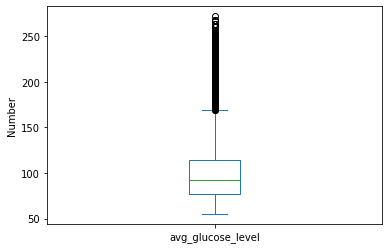

In [12]:
df['avg_glucose_level'].plot(kind='box')
plt.ylabel('Number');
plt.show()

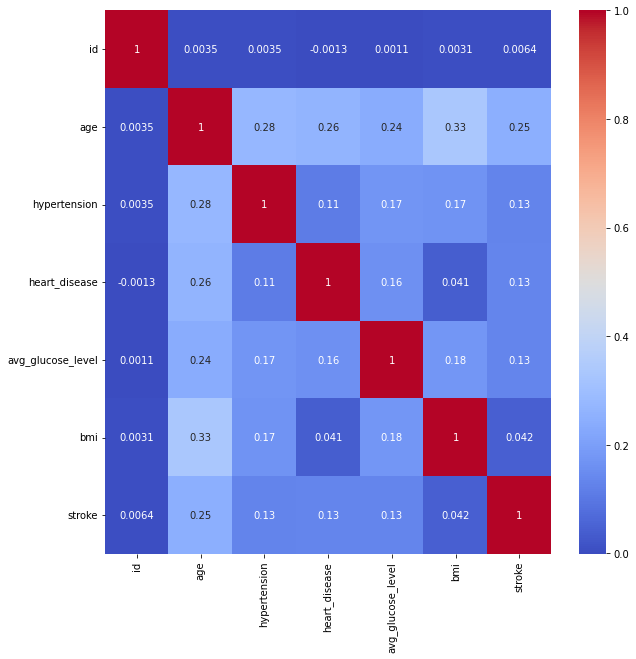

In [13]:
correlation = df_ml['avg_glucose_level'].corr(df_ml['stroke'])
correlation

corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Creating a multivariate exploratory visualization

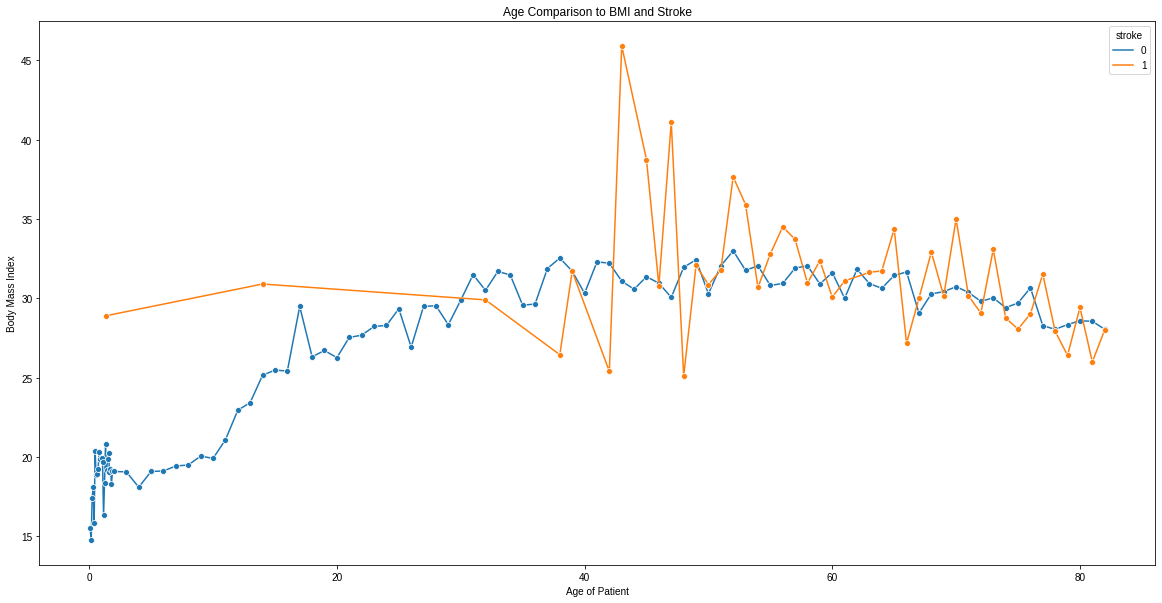

In [14]:
plt.figure(figsize=(20,10))
sns.lineplot(data = df_ml, x = 'age', y = 'bmi', hue = 'stroke', ci = None, marker = 'o')

plt.style.use('seaborn-darkgrid')
plt.title('Age Comparison to BMI and Stroke')
plt.xlabel('Age of Patient')
plt.ylabel('Body Mass Index');
plt.savefig('lineplot.png')
# bmi = Body Mass Index

- The line plot above shows us a lot of data points but what really stands out from all the points is the orange dots on the far right. Looking at these it seems that there is a possible correlation between the age over 40 and the occurence of a stroke in disregurades to ones body mass index.

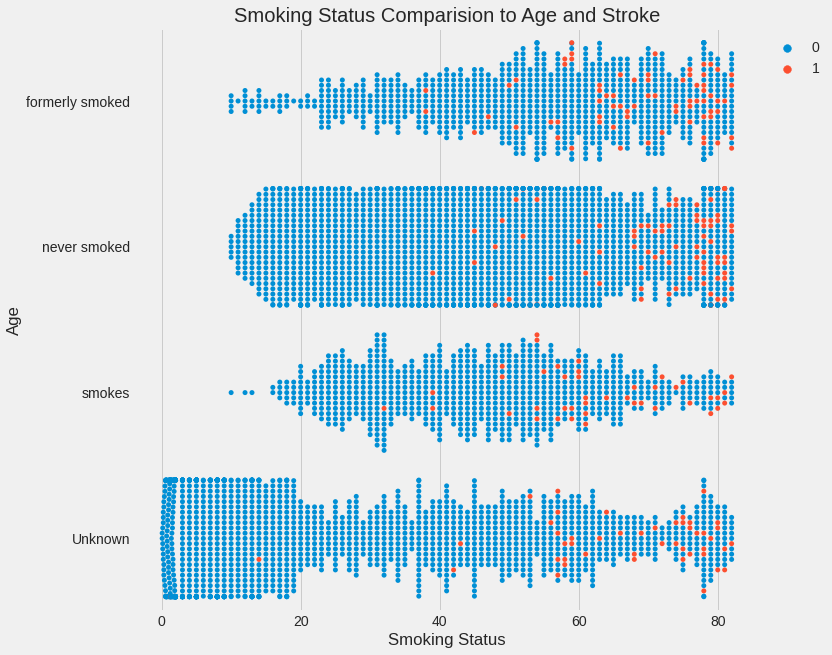

In [26]:
plt.figure(figsize=(10,10))
sns.swarmplot(data = df_ml, x = 'age', y = 'smoking_status', hue = 'stroke')
plt.style.use('fivethirtyeight')
plt.title('Smoking Status Comparision to Age and Stroke')
plt.xlabel('Smoking Status')
plt.ylabel('Age');
plt.legend(bbox_to_anchor=(1,1));
plt.savefig('Swarmplotplot.png')

- The barplot aboves shows us the comparison of and individuals smoking status, age, and the occurence of a stroke. We can see judging by this that smoking does not effect your probability perhaps. we can also see under the "Never Smoked" bar that age was the deciding factor on the occurence of a stroke. 

- Conclusion:
 - Judging by these two graphs we could say that there is a likley connection between an individuals age and the probability of stroke regardless of smoking or body mass index.

## Further preprocessing and model development

In [16]:
df_ml.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [17]:
# Assign feature matrix and target vector
X = df_ml.drop(columns=['stroke'])
y = df_ml['stroke']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

# create preprocessing pipeline
base_preprocess = make_column_transformer((ohe, cat_cols), (scaler, num_cols))

- Logistic regression Model

In [18]:
# Make model
logreg = LogisticRegression()
logreg_pipe = make_pipeline(base_preprocess, logreg)

# Fix the model to the training data
logreg_pipe.fit(X_train,y_train)

train_preds_log = logreg_pipe.predict(X_train)
test_preds_log = logreg_pipe.predict(X_test)

print(logreg_pipe.score(X_train, y_train))
print(logreg_pipe.score(X_test, y_test))

0.9558977035490606
0.9381846635367762


In [19]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
# Iterative over the c values
for c in c_values:
  # Instantiate a model with each value of c and fit it on the data
  logregl2 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  logreg_pipe2 = make_pipeline(base_preprocess, logregl2)

  logreg_pipe2.fit(X_train,y_train)

  train_scores.append(logreg_pipe2.score(X_train, y_train))
  test_scores.append(logreg_pipe2.score(X_test, y_test))
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.9374021909233177,
 0.001: 0.9374021909233177,
 0.01: 0.9374021909233177,
 0.1: 0.9374021909233177,
 1: 0.9381846635367762,
 10: 0.9381846635367762,
 100: 0.9381846635367762,
 1000: 0.9381846635367762}

- No dramatic change in performance with logistic Regression and L2 tuning

- KNN and Random Forest Models

In [20]:
#Run KNN Model
knn = KNeighborsClassifier(n_neighbors=6)

knn_pipe = make_pipeline(base_preprocess, knn)
knn_pipe.fit(X_train, y_train)

train_preds_knn = logreg_pipe.predict(X_train)
test_preds_knn = logreg_pipe.predict(X_test)

predictions = knn_pipe.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
# calculate classification accuracy
print('Accuracy of Train set', accuracy_score(y_train, train_preds_knn))
print('Accuracy of Test set', accuracy_score(y_test, test_preds_knn))

Accuracy of Train set 0.9558977035490606
Accuracy of Test set 0.9381846635367762


In [22]:
#Tuning K in KNN 
krange = range(1, 15)
test_accuracies = []
bestacc = 0
bestk = 0
for k in krange:
  #find accuracy for each k
  knn_pipe2 = make_pipeline(base_preprocess, KNeighborsClassifier(n_neighbors=k))
  knn_pipe2.fit(X_train, y_train)
  acc = accuracy_score(y_test, knn_pipe2.predict(X_test))
  #if accuracy for this k is better than previous accuracies, set bestk = k
  if acc > bestacc:
    bestacc = acc
    bestk = k
  test_accuracies.append(acc)

# print best k and best accuracy
print(f'Best K value is {bestk} \nwith {bestacc} accuracy on the test set')

Best K value is 6 
with 0.9374021909233177 accuracy on the test set


- Not very happy with how this model preformed, the Logistic regression was still slighty better.

In [23]:
# Using GridsearchCV on KNN Model
pipe_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}

In [24]:
# New KNN Model with GridSearch
knn_pipe_gs = GridSearchCV(knn_pipe, pipe_param_grid)

# Fitting new model to train data
knn_pipe_gs.fit(X_train, y_train)

# Looking at best parameters after GridSearchCV
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

KeyboardInterrupt: ignored

- Even after tuning using GridSearchCV the best KNN Model can only predict about 93% accuracy.

## PCA Feature Engineering

In [ ]:
# Making a KNN Model with PCA 
pca = PCA(n_components=0.95)

# Fitting and transforming the model onto the X_train
pca_model = make_pipeline(base_preprocess, pca)
pca_model.fit_transform(X_train)

knn_pipepca = make_pipeline(pca_model, knn)
knn_pipepca.fit(X_train, y_train)

# Checking predictions
preds_pca = knn_pipepca.predict(X_test)
test_report_pca = classification_report(y_test, preds_pca)

print(test_report_pca)

- Using PCA Method gave us a small boost in preformance of the Logistic model (Accuracy), for this reason I would choose this model for my "Production" model as it is the higest prefoming model so far.